# Data description & Problem statement: 
The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes. Please check the description at: https://archive.ics.uci.edu/ml/datasets/auto+mpg

* The data has 398 rows and 9 variables.
* This is a Regression problem. We predict the Auto MPG.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial RF model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of RF model: Find the best RF model
   # Model Evaluation: 
- Evaluate the best RF model with optimized hyperparameters on Test Dataset, by calculating:
     - r2 (determination factor)
     - Lift chart
     - RMSE 
     - Box-plot for prediction Vs. actual values 
     - Distribution plot of error/residuals
     
Finally, calculate the Feature Importance for the features 

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/mpg/mpg.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
name            398 non-null object
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [3]:
df['horsepower'] = df['horsepower'].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)
df.drop(['name' ], axis=1, inplace=True)

In [4]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
for name in ['origin']:
    encode_text_dummy(df, name)
    
df.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin-1,origin-2,origin-3
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
model_year      392 non-null int64
origin-1        392 non-null uint8
origin-2        392 non-null uint8
origin-3        392 non-null uint8
dtypes: float64(4), int64(3), uint8(3)
memory usage: 25.6 KB


In [6]:
X=df.drop(['mpg'], axis=1)
y=np.log(df['mpg'])

# Re-scaling:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scalor_X=MinMaxScaler().fit(pd.DataFrame(X_train))
X_train=scalor_X.transform(pd.DataFrame(X_train))
X_test=scalor_X.transform(pd.DataFrame(X_test))

scaler_y=MinMaxScaler().fit(pd.DataFrame(y_train))
y_train=scaler_y.transform(pd.DataFrame(y_train))
y_test=scaler_y.transform(pd.DataFrame(y_test))

In [7]:
# We build the Initial Model & Cross-Validation:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

model=RandomForestRegressor(max_features=9, n_estimators=200, max_depth=7, random_state=42)

kfold=KFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold)

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.81918043 0.91420008 0.90005411 0.89842835 0.88630641] 

Accuracy: 0.88 (+/- 0.03)


In [8]:
# Grid-Serach for the best model parameters: 
from sklearn.model_selection import GridSearchCV

param={'max_depth':[2, 3, 5, 7, 10, 15], 'max_features':[2, 3, 5, 7, 9], 'n_estimators': [10, 50, 200]}

kfold=KFold(n_splits=4, shuffle=True, random_state=42)
grid_search=GridSearchCV(RandomForestRegressor(random_state=42), param, cv=kfold, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

G=pd.DataFrame(grid_search.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
68,0.360285,0.003260,0.013464,0.000499,10,5,200,"{'max_depth': 10, 'max_features': 5, 'n_estima...",0.836542,0.915335,...,0.883318,0.879378,0.028146,1,0.985890,0.981490,0.984576,0.983513,0.983867,0.001610
65,0.337347,0.004591,0.012966,0.000705,10,3,200,"{'max_depth': 10, 'max_features': 3, 'n_estima...",0.839312,0.914806,...,0.877143,0.878743,0.026919,2,0.984998,0.980510,0.983362,0.981905,0.982694,0.001669
53,0.342833,0.006994,0.013214,0.000432,7,5,200,"{'max_depth': 7, 'max_features': 5, 'n_estimat...",0.838367,0.911827,...,0.879777,0.878635,0.026353,3,0.977656,0.971513,0.975491,0.975666,0.975082,0.002229


In [9]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'max_depth': 10, 'max_features': 5, 'n_estimators': 200}
Best validation accuracy:  0.88 (+/- 0.03)
Test score:  0.91


('displacement', 0.4241408116649857)
('weight', 0.23159397522747568)
('cylinders', 0.13887540275283208)
('horsepower', 0.1050159497463366)
('model_year', 0.0793815922650313)
('acceleration', 0.018098594384213983)
('origin-3', 0.00119628072519307)
('origin-2', 0.001096675525646062)
('origin-1', 0.0006007177082855771)


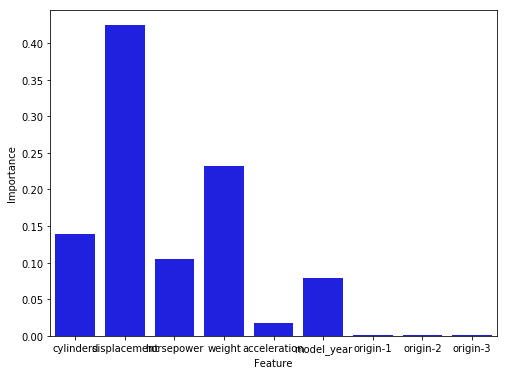

In [10]:
# Feature Importance:
im=RandomForestRegressor( max_depth= 5, max_features= 5, n_estimators= 25, random_state=42).fit(X,y).feature_importances_

# Sort & Plot:
d=dict(zip(X.columns, im))
k=sorted(d,key=lambda i: d[i], reverse= True)
[print((i,d[i])) for i in k]

# Plot:
c1=pd.DataFrame(np.array(im),  columns=["Importance"])
c2=pd.DataFrame(X.columns, columns=["Feature"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.barplot(x="Feature", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)

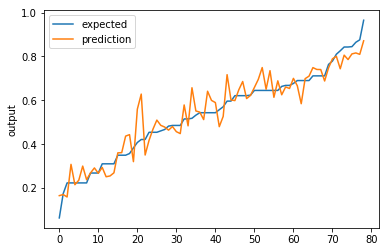

In [11]:
# Plot the Lift Chart:

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

pred=grid_search.predict(X_test)
chart_regression(pred.flatten(), np.array(y_test), sort=True)

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_inv=scaler_y.inverse_transform(pd.DataFrame(pred))
y_test_inv=scaler_y.inverse_transform(y_test)

rmse = sqrt(mean_squared_error(np.e**y_test_inv, np.e**pred_inv))
print('Test rmse: ', rmse)

Test rmse:  2.3034379965878786


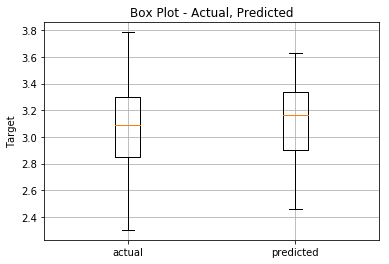

In [13]:
plt.boxplot([y_test_inv.ravel(), pred_inv.ravel()], labels=['actual','predicted'])
plt.title('Box Plot - Actual, Predicted')
plt.ylabel('Target')
plt.grid(True)

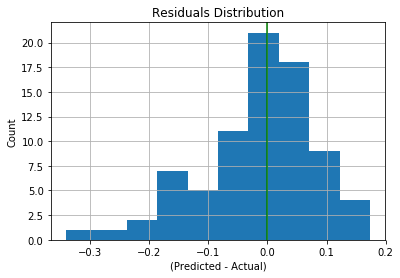

In [14]:
# Over prediction and Under Prediction needs to be balanced:
# Training Data Residuals
residuals = y_test_inv.ravel()-pred_inv.ravel()

plt.hist(residuals)
plt.grid(True)
plt.xlabel('(Predicted - Actual)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.axvline(color='g')
plt.show()

('displacement', 0.5427458636676037)
('weight', 0.15994413625367548)
('horsepower', 0.12488054838097798)
('model_year', 0.08570968364131579)
('cylinders', 0.06254172385369414)
('acceleration', 0.021228017027056588)
('origin-3', 0.001549999397210368)
('origin-1', 0.00105468690712981)
('origin-2', 0.0003453408713362788)


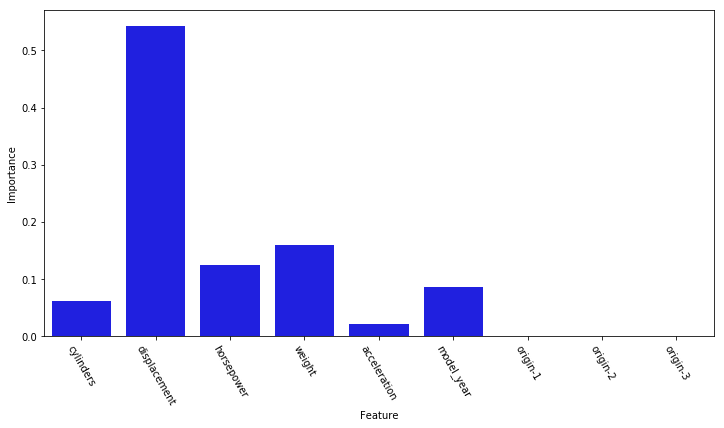

In [15]:
im=RandomForestRegressor().fit(X, y).feature_importances_

# Sort & Plot:
d=dict(zip(np.array(X.columns), im))
k=sorted(d,key=lambda i: d[i], reverse= True)
[print((i,d[i])) for i in k]

# Plot:
c1=pd.DataFrame(np.array(im),  columns=["Importance"])
c2=pd.DataFrame(np.array(X.columns),columns=["Feature"])

fig, ax = plt.subplots(figsize=(12,6)) 
sns.barplot(x="Feature", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)
plt.xticks(rotation=-60)
plt.show()